# Binary Classification

In [1]:
import pandas as pd
import numpy as np

In [6]:
n_samples = 100
data = {
    'Monthly Salary': np.random.normal(5000, 2000, n_samples),  # Numerical
    'Avg Account Balance': np.random.normal(10000, 5000, n_samples),  # Numerical
    'Number of Bank Accounts': np.random.randint(1, 4, n_samples),  # Numerical
    'Age': np.random.randint(18, 80, n_samples),  # Numerical (no nulls)
    'Card Type': np.random.choice(['Visa', 'MasterCard', 'None'], n_samples, p=[0.4, 0.4, 0.2]),  # Nominal
    'Marital Status': np.random.choice(['Single', 'Married', 'Divorced', 'Widow'], n_samples, p=[0.5, 0.3, 0.1, 0.1]),  # Nominal
    'Employment Industry': np.random.choice(['Tech', 'Finance', 'Healthcare', 'Other'], n_samples, p=[0.3, 0.3, 0.2, 0.2]),  # Nominal
    'Education': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], n_samples, p=[0.4, 0.4, 0.15, 0.05]),  # Ordinal
    'Residence Type': np.random.choice(['Rent', 'Own', 'Other'], n_samples, p=[0.4, 0.5, 0.1]),  # Ordinal
    'Credit Default': np.random.binomial(1, 0.3, n_samples)  # Binary target
}

df = pd.DataFrame(data)
null_cols = ['Monthly Salary', 'Avg Account Balance', 'Number of Bank Accounts', 'Card Type', 'Marital Status', 'Employment Industry', 'Education', 'Residence Type']
for col in null_cols:
    null_mask = np.random.choice([True, False], n_samples, p=[0.15, 0.85])
    df.loc[null_mask, col] = np.nan

df.head()

,Monthly Salary,Avg Account Balance,Number of Bank Accounts,Age,Card Type,Marital Status,Employment Industry,Education,Residence Type,Credit Default
0,4408.917520,2407.755280,2.0,56,Visa,Single,Tech,High School,Rent,0
1,5304.631027,16219.264663,3.0,45,NaN,Widow,Tech,High School,Other,0
2,5758.964114,9484.883993,1.0,20,MasterCard,Single,Healthcare,High School,Other,1
3,8623.009625,16125.661741,1.0,37,None,NaN,Healthcare,High School,Rent,0
4,4834.704430,10189.752181,1.0,23,MasterCard,Married,Finance,Bachelor,Own,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Monthly Salary           85 non-null     float64
 1   Avg Account Balance      88 non-null     float64
 2   Number of Bank Accounts  90 non-null     float64
 3   Age                      100 non-null    int32  
 4   Card Type                91 non-null     object 
 5   Marital Status           81 non-null     object 
 6   Employment Industry      85 non-null     object 
 7   Education                92 non-null     object 
 8   Residence Type           85 non-null     object 
 9   Credit Default           100 non-null    int32  
dtypes: float64(3), int32(2), object(5)
memory usage: 7.2+ KB


In [8]:
# Define feature types
num_cols = ['Monthly Salary', 'Avg Account Balance', 'Number of Bank Accounts', 'Age']
nominal_cols = ['Card Type', 'Marital Status', 'Employment Industry']
ordinal_cols = ['Education', 'Residence Type']
all_features = num_cols + nominal_cols + ordinal_cols

In [9]:
all_features

['Monthly Salary',
 'Avg Account Balance',
 'Number of Bank Accounts',
 'Age',
 'Card Type',
 'Marital Status',
 'Employment Industry',
 'Education',
 'Residence Type']

In [10]:
education_categories = ['High School', 'Bachelor', 'Master', 'PhD']
residence_categories = ['Rent', 'Own', 'Other']

In [18]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=5, weights='uniform'))
])

nominal_transformer = Pipeline(
    steps=[('imputer',SimpleImputer(strategy='most_frequent')), 
           ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
          ])

ordinal_transformer = Pipeline(
    steps=[('imputer',SimpleImputer(strategy='most_frequent')), 
           ('ordinal', OrdinalEncoder(categories=[education_categories, residence_categories]))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('nominal', nominal_transformer, nominal_cols),
        ('ordinal', ordinal_transformer, ordinal_cols)
    ])

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
# Create pipeline with feature selection and classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [20]:
from sklearn.model_selection import train_test_split

# Split data (80 train, 20 test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
# Prepare data
X_train = train_df[all_features]
y_train = train_df['Credit Default']
X_test = test_df[all_features]
y_test = test_df['Credit Default']

pipeline.fit(X_train, y_train)

# Get selected features
feature_names = (num_cols + 
                 list(pipeline.named_steps['preprocessor'].named_transformers_['nominal']['onehot'].get_feature_names_out(nominal_cols)) + 
                 ordinal_cols)
selected_mask = pipeline.named_steps['feature_selection'].get_support()
selected_features = [feature_names[i] for i in range(len(feature_names)) if selected_mask[i]]
print("Selected Features:", selected_features)

Selected Features: ['Monthly Salary', 'Avg Account Balance', 'Age']


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Predict on test set
y_pred = pipeline.predict(X_test)

# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [23]:
print("\nPerformance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Performance Metrics:
Accuracy: 0.6500
Precision: 0.5000
Recall: 0.1429
F1-Score: 0.2222


In [24]:
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[12  1]
 [ 6  1]]


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Default (0)', 'Default (1)'],
            yticklabels=['No Default (0)', 'Default (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')
plt.close()

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))

# Save pipeline
# with open('rf_pipeline.pkl', 'wb') as f:
#     pickle.dump(pipeline, f)


Classification Report:
              precision    recall  f1-score   support

  No Default       0.67      0.92      0.77        13
     Default       0.50      0.14      0.22         7

    accuracy                           0.65        20
   macro avg       0.58      0.53      0.50        20
weighted avg       0.61      0.65      0.58        20



# Regression Analysis

In [27]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# Set random seed for reproducibility
np.random.seed(42)

# Create synthetic dataset (100 records)
n_samples = 100
data = {
    'Square Footage': np.random.normal(2000, 500, n_samples),  # Numerical
    'Lot Size': np.random.normal(6000, 2000, n_samples),  # Numerical
    'Bedrooms': np.random.randint(1, 6, n_samples),  # Numerical
    'Age': np.random.randint(0, 50, n_samples),  # Numerical
    'House Type': np.random.choice(['Single Family', 'Condo', 'Townhouse'], n_samples, p=[0.5, 0.3, 0.2]),  # Nominal
    'City': np.random.choice(['Suburban', 'Urban', 'Rural'], n_samples, p=[0.4, 0.4, 0.2]),  # Nominal
    'Neighborhood Quality': np.random.choice(['Low', 'Medium', 'High'], n_samples, p=[0.3, 0.5, 0.2]),  # Ordinal
    'Condition': np.random.choice(['Poor', 'Average', 'Excellent'], n_samples, p=[0.2, 0.6, 0.2]),  # Ordinal
    # Target: House Price (in thousands)
    'House Price': 100 + 0.1 * np.random.normal(2000, 500, n_samples) + 0.05 * np.random.normal(6000, 2000, n_samples) + np.random.normal(0, 50, n_samples)
}

df = pd.DataFrame(data)

In [29]:
df.head()

,Square Footage,Lot Size,Bedrooms,Age,House Type,City,Neighborhood Quality,Condition,House Price
0,2248.357077,3169.258516,2,30,Single Family,Urban,Medium,Poor,429.837143
1,1930.867849,5158.709354,2,9,Townhouse,Rural,Low,Poor,477.437020
2,2323.844269,5314.570967,1,18,Condo,Suburban,Medium,Average,780.179700
3,2761.514928,4395.445462,1,31,Single Family,Rural,Medium,Average,639.098415
4,1882.923313,5677.428577,1,0,Single Family,Urban,Medium,Average,471.630596


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Square Footage        100 non-null    float64
 1   Lot Size              100 non-null    float64
 2   Bedrooms              100 non-null    int32  
 3   Age                   100 non-null    int32  
 4   House Type            100 non-null    object 
 5   City                  100 non-null    object 
 6   Neighborhood Quality  100 non-null    object 
 7   Condition             100 non-null    object 
 8   House Price           100 non-null    float64
dtypes: float64(3), int32(2), object(4)
memory usage: 6.4+ KB


In [31]:
# Introduce nulls (~10-15% in train/test)
null_cols = ['Square Footage', 'Lot Size', 'Bedrooms', 'House Type', 'City', 'Neighborhood Quality', 'Condition']
for col in null_cols:
    null_mask = np.random.choice([True, False], n_samples, p=[0.15, 0.85])
    df.loc[null_mask, col] = np.nan

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Square Footage        86 non-null     float64
 1   Lot Size              88 non-null     float64
 2   Bedrooms              85 non-null     float64
 3   Age                   100 non-null    int32  
 4   House Type            90 non-null     object 
 5   City                  86 non-null     object 
 6   Neighborhood Quality  85 non-null     object 
 7   Condition             80 non-null     object 
 8   House Price           100 non-null    float64
dtypes: float64(4), int32(1), object(4)
memory usage: 6.8+ KB


In [32]:
# Split data (80 train, 20 test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [33]:
# Define feature types
num_cols = ['Square Footage', 'Lot Size', 'Bedrooms', 'Age']
nominal_cols = ['House Type', 'City']
ordinal_cols = ['Neighborhood Quality', 'Condition']
all_features = num_cols + nominal_cols + ordinal_cols

In [34]:
# Define ordinal categories (ordered)
neighborhood_categories = ['Low', 'Medium', 'High']
condition_categories = ['Poor', 'Average', 'Excellent']

In [35]:
# Create preprocessing pipeline
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=5, weights='uniform'))
])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[neighborhood_categories, condition_categories]))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('nominal', nominal_transformer, nominal_cols),
        ('ordinal', ordinal_transformer, ordinal_cols)
    ])

In [36]:
# Create pipeline with feature selection and Linear Regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(LinearRegression())),
    ('regressor', LinearRegression())
])

In [37]:
# Prepare data
X_train = train_df[all_features]
y_train = train_df['House Price']
X_test = test_df[all_features]
y_test = test_df['House Price']

In [38]:
# Fit pipeline
pipeline.fit(X_train, y_train)

# Get selected features
feature_names = (num_cols + 
                 list(pipeline.named_steps['preprocessor'].named_transformers_['nominal']['onehot'].get_feature_names_out(nominal_cols)) + 
                 ordinal_cols)
selected_mask = pipeline.named_steps['feature_selection'].get_support()
selected_features = [feature_names[i] for i in range(len(feature_names)) if selected_mask[i]]
print("Selected Features:", selected_features)

Selected Features: ['Bedrooms', 'Age', 'House Type_Townhouse', 'City_Suburban', 'Neighborhood Quality']


In [39]:
# Predict on test set
y_pred = pipeline.predict(X_test)

# Performance metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nPerformance Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


Performance Metrics:
R² Score: -0.3669
RMSE: 126.4006
MAE: 95.9821


Text(0, 0.5, 'Residuals')

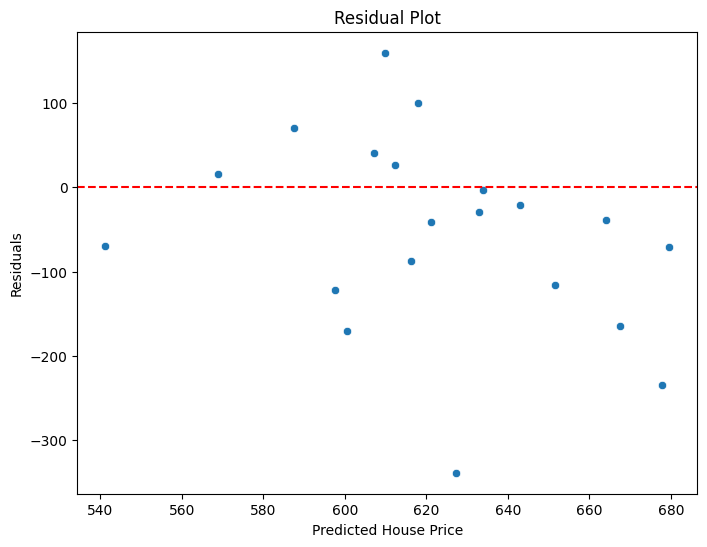

In [42]:
# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted House Price')
plt.ylabel('Residuals')
# plt.savefig('residual_plot.png')
# plt.close()

# Multi-Class Classification

In [43]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
n_samples = 100
data = {
    'Income': np.random.normal(60000, 20000, n_samples),  # Numerical
    'Credit Score': np.random.normal(700, 50, n_samples),  # Numerical
    'Debt Ratio': np.random.uniform(0.1, 0.5, n_samples),  # Numerical
    'Age': np.random.randint(18, 80, n_samples),  # Numerical
    'Occupation': np.random.choice(['Engineer', 'Teacher', 'Sales', 'Other'], n_samples, p=[0.3, 0.3, 0.2, 0.2]),  # Nominal
    'Region': np.random.choice(['Urban', 'Suburban', 'Rural'], n_samples, p=[0.4, 0.4, 0.2]),  # Nominal
    'Education Level': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], n_samples, p=[0.4, 0.4, 0.15, 0.05]),  # Ordinal
    'Loan History': np.random.choice(['Poor', 'Fair', 'Good'], n_samples, p=[0.3, 0.4, 0.3]),  # Ordinal
    # Multiclass target: Credit Risk (Low=0, Medium=1, High=2)
    'Credit Risk': np.random.choice([0, 1, 2], n_samples, p=[0.4, 0.4, 0.2])
}

In [45]:
df = pd.DataFrame(data)
df.head()

,Income,Credit Score,Debt Ratio,Age,Occupation,Region,Education Level,Loan History,Credit Risk
0,80039.045356,752.652872,0.489383,72,Engineer,Suburban,High School,Good,1
1,64100.533741,801.665265,0.234736,33,Sales,Urban,High School,Good,1
2,36136.907078,634.312109,0.218596,46,Engineer,Urban,High School,Good,1
3,55342.131735,645.234919,0.467283,79,Engineer,Suburban,Bachelor,Fair,0
4,86536.188401,691.560161,0.144299,66,Teacher,Urban,High School,Fair,1


In [47]:
df['Credit Risk'].value_counts()

Credit Risk
0    42
1    38
2    20
Name: count, dtype: int64

In [50]:
# Introduce nulls (~10-15% in train/test)
null_cols = ['Income', 'Credit Score', 'Debt Ratio', 'Occupation', 'Region', 'Education Level', 'Loan History']
for col in null_cols:
    null_mask = np.random.choice([True, False], n_samples, p=[0.15, 0.85])
    df.loc[null_mask, col] = np.nan

# Split data (80 train, 20 test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [51]:
# Define feature types
num_cols = ['Income', 'Credit Score', 'Debt Ratio', 'Age']
nominal_cols = ['Occupation', 'Region']
ordinal_cols = ['Education Level', 'Loan History']
all_features = num_cols + nominal_cols + ordinal_cols

# Define ordinal categories (ordered)
education_categories = ['High School', 'Bachelor', 'Master', 'PhD']
loan_history_categories = ['Poor', 'Fair', 'Good']

# Create preprocessing pipeline
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=5, weights='uniform'))
])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[education_categories, loan_history_categories]))
])

In [52]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('nominal', nominal_transformer, nominal_cols),
        ('ordinal', ordinal_transformer, ordinal_cols)
    ])

# Create pipeline with feature selection and Random Forest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [53]:
# Prepare data
X_train = train_df[all_features]
y_train = train_df['Credit Risk']
X_test = test_df[all_features]
y_test = test_df['Credit Risk']

In [54]:
# Fit pipeline
pipeline.fit(X_train, y_train)

# Get selected features
feature_names = (num_cols + 
                 list(pipeline.named_steps['preprocessor'].named_transformers_['nominal']['onehot'].get_feature_names_out(nominal_cols)) + 
                 ordinal_cols)
selected_mask = pipeline.named_steps['feature_selection'].get_support()
selected_features = [feature_names[i] for i in range(len(feature_names)) if selected_mask[i]]
print("Selected Features:", selected_features)

Selected Features: ['Income', 'Credit Score', 'Debt Ratio', 'Age', 'Education Level']


In [55]:
# Predict on test set
y_pred = pipeline.predict(X_test)

# Performance metrics (macro-averaged for multiclass)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\nPerformance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"F1-Score (Macro): {f1:.4f}")


Performance Metrics:
Accuracy: 0.4500
Precision (Macro): 0.4984
Recall (Macro): 0.4583
F1-Score (Macro): 0.4481



Confusion Matrix:
[[4 2 0]
 [4 3 1]
 [2 2 2]]


Text(70.72222222222221, 0.5, 'Actual')

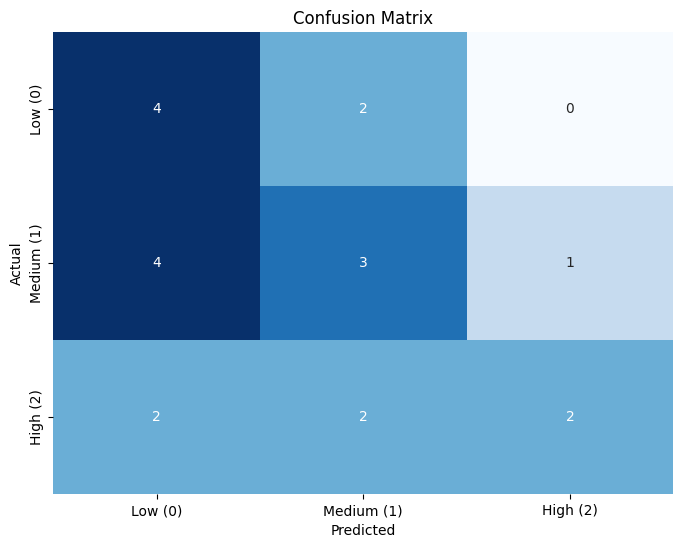

In [57]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Low (0)', 'Medium (1)', 'High (2)'],
            yticklabels=['Low (0)', 'Medium (1)', 'High (2)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
# plt.savefig# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

In [58]:
# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))


Classification Report:
              precision    recall  f1-score   support

         Low       0.40      0.67      0.50         6
      Medium       0.43      0.38      0.40         8
        High       0.67      0.33      0.44         6

    accuracy                           0.45        20
   macro avg       0.50      0.46      0.45        20
weighted avg       0.49      0.45      0.44        20



# Clustering 

In [59]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
# Create synthetic dataset (100 records)
n_samples = 100
data = {
    'Income': np.random.normal(60000, 20000, n_samples),  # Numerical
    'Spending Score': np.random.normal(50, 20, n_samples),  # Numerical
    'Debt Ratio': np.random.uniform(0.1, 0.5, n_samples),  # Numerical
    'Age': np.random.randint(18, 80, n_samples),  # Numerical
    'Occupation': np.random.choice(['Engineer', 'Teacher', 'Sales', 'Other'], n_samples, p=[0.3, 0.3, 0.2, 0.2]),  # Nominal
    'Region': np.random.choice(['Urban', 'Suburban', 'Rural'], n_samples, p=[0.4, 0.4, 0.2]),  # Nominal
    'Education Level': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], n_samples, p=[0.4, 0.4, 0.15, 0.05]),  # Ordinal
    'Credit Usage': np.random.choice(['Low', 'Medium', 'High'], n_samples, p=[0.3, 0.4, 0.3])  # Ordinal
}

df = pd.DataFrame(data)

# Introduce nulls (~10-15% in train/test)
null_cols = ['Income', 'Spending Score', 'Debt Ratio', 'Occupation', 'Region', 'Education Level', 'Credit Usage']
for col in null_cols:
    null_mask = np.random.choice([True, False], n_samples, p=[0.15, 0.85])
    df.loc[null_mask, col] = np.nan

df.head()

,Income,Spending Score,Debt Ratio,Age,Occupation,Region,Education Level,Credit Usage
0,80861.227546,45.853225,0.222281,33,NaN,Urban,Bachelor,Medium
1,87248.038709,68.300398,NaN,18,Sales,NaN,High School,Medium
2,66199.373220,NaN,0.360747,68,Engineer,Urban,Bachelor,Low
3,NaN,26.704060,NaN,54,Teacher,NaN,Bachelor,Medium
4,65110.355133,52.039019,NaN,56,Engineer,Suburban,Bachelor,NaN


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Income           85 non-null     float64
 1   Spending Score   86 non-null     float64
 2   Debt Ratio       85 non-null     float64
 3   Age              100 non-null    int32  
 4   Occupation       82 non-null     object 
 5   Region           86 non-null     object 
 6   Education Level  82 non-null     object 
 7   Credit Usage     80 non-null     object 
dtypes: float64(3), int32(1), object(4)
memory usage: 6.0+ KB


In [64]:
# Split data (80 train, 20 test) for preprocessing consistency
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [65]:
# Define feature types
num_cols = ['Income', 'Spending Score', 'Debt Ratio', 'Age']
nominal_cols = ['Occupation', 'Region']
ordinal_cols = ['Education Level', 'Credit Usage']
all_features = num_cols + nominal_cols + ordinal_cols

# Define ordinal categories (ordered)
education_categories = ['High School', 'Bachelor', 'Master', 'PhD']
credit_usage_categories = ['Low', 'Medium', 'High']

# Create preprocessing pipeline
num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5, weights='uniform')),
    ('scaler', StandardScaler())
])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[education_categories, credit_usage_categories]))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('nominal', nominal_transformer, nominal_cols),
        ('ordinal', ordinal_transformer, ordinal_cols)
    ])

# Create pipeline with feature selection
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('variance_threshold', VarianceThreshold(threshold=0.1))
])

In [66]:
# Fit and transform training data
X_train_processed = pipeline.fit_transform(train_df[all_features])
X_test_processed = pipeline.transform(test_df[all_features])

In [67]:
# Get feature names after preprocessing
nominal_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['nominal']['onehot'].get_feature_names_out(nominal_cols)
feature_names = num_cols + list(nominal_feature_names) + ordinal_cols

# Apply variance threshold to get selected features
selected_mask = pipeline.named_steps['variance_threshold'].get_support()
selected_features = [feature_names[i] for i in range(len(feature_names)) if selected_mask[i]]
print("Selected Features:", selected_features)

# Combine train and test for clustering (after preprocessing)
X_all_processed = np.vstack([X_train_processed, X_test_processed])
df_all = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

Selected Features: ['Income', 'Spending Score', 'Debt Ratio', 'Age', 'Occupation_Other', 'Occupation_Sales', 'Occupation_Teacher', 'Region_Suburban', 'Region_Urban', 'Education Level', 'Credit Usage']


In [68]:
# Determine optimal number of clusters (elbow method)
inertias = []
silhouette_scores = []
k_range = range(2, 6)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_all_processed)
    inertias.append(kmeans.inertia_)
    if k > 1:
        score = silhouette_score(X_all_processed, kmeans.labels_)
        silhouette_scores.append(score)

Text(0, 0.5, 'Inertia')

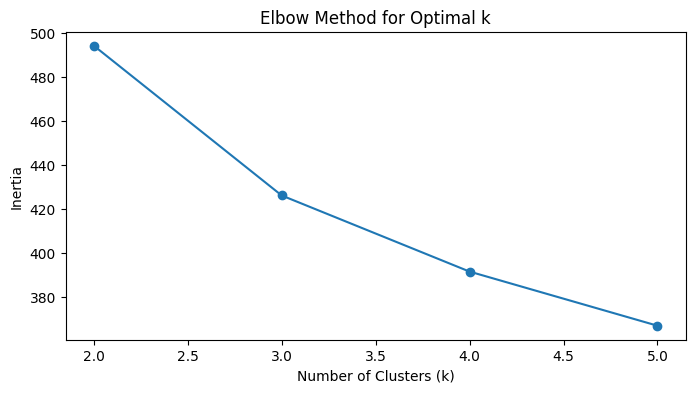

In [69]:
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

In [70]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_all_processed)

In [71]:
# Add cluster labels to original DataFrame
df_all['Cluster'] = cluster_labels

In [72]:
# Evaluation metrics
silhouette_avg = silhouette_score(X_all_processed, cluster_labels)
inertia = kmeans.inertia_

In [73]:
print("\nClustering Metrics:")
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Inertia: {inertia:.4f}")


Clustering Metrics:
Silhouette Score: 0.1374
Inertia: 426.2290


Text(0, 0.5, 'PCA Component 2')

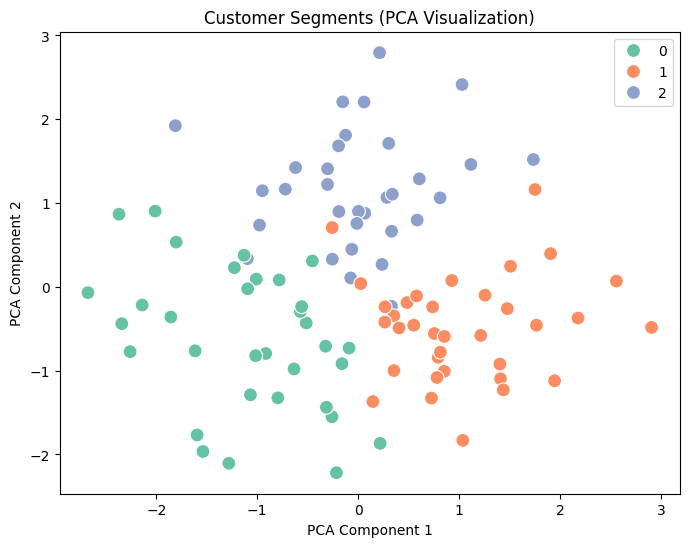

In [74]:
# Visualize clusters with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all_processed)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='Set2', s=100)
plt.title('Customer Segments (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

In [75]:
# Cluster summary
print("\nCluster Summary:")
for cluster in range(optimal_k):
    cluster_data = df_all[df_all['Cluster'] == cluster]
    print(f"\nCluster {cluster} (n={len(cluster_data)}):")
    print(cluster_data[['Income', 'Spending Score', 'Age', 'Education Level', 'Occupation']].describe(include='all'))


Cluster Summary:

Cluster 0 (n=33):
              Income  Spending Score        Age Education Level Occupation
count      27.000000       31.000000  33.000000              28         26
unique           NaN             NaN        NaN               4          4
top              NaN             NaN        NaN     High School    Teacher
freq             NaN             NaN        NaN              12          9
mean    48688.837604       32.059575  53.848485             NaN        NaN
std     19261.436378       18.362704  16.667936             NaN        NaN
min     17659.838956       -7.683089  25.000000             NaN        NaN
25%     37735.646806       20.638023  39.000000             NaN        NaN
50%     45611.679184       30.264896  53.000000             NaN        NaN
75%     61947.662201       45.976998  72.000000             NaN        NaN
max     87573.428346       65.975373  78.000000             NaN        NaN

Cluster 1 (n=35):
              Income  Spending Score        